# GESTURE RECOGNITION CASE STUDY

### PROBLEM STATEMENT

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

#### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [84]:
# Importing the necessary libraries

import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import imageio
import imageio.v2 as imageio
from PIL import Image
from skimage.transform import resize as imresize
import cv2
import matplotlib.pyplot as plt

In [85]:
#Initialization using seed so that the results may not vary drastically.

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [45]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, AveragePooling3D
#from keras.layers.pooling import AveragePooling3D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [46]:
# Loading the Project Data folder containing train and test subfolders along with train and test docs

#project_folder=r'/kaggle/input/project-data/Project_data'
project_folder=r'C:\Users\gchalla\Downloads\Project_data\Project_data'

In [47]:
#Collecting data from csv files randomly instead of sequentially
train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())

In [48]:
# Train and Validation folders path which are in Project Data and used frequently to access the folders
curr_dt_time = datetime.datetime.now()
print (curr_dt_time)
#train_path = r'/kaggle/input/project-data/Project_data/train'
#val_path = r'/kaggle/input/project-data/Project_data/val'
train_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\train'
val_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [49]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

In [50]:
# Generator method to parse the folders based on batch size. Also processing the images and resizing them
 
def generator(source_path, folder_list, batch_size,y,z,frames_to_sample=15,augmentation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames=30
    #frames_to_sample=15
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int) #Image indexes to be selected based on no.of frames from 30 images
    while True:
        t = np.random.permutation(folder_list)  # Randomizing the folder_list
        num_batches = len(t)//batch_size    # calculate the number of batches
        for batch in range(num_batches):    # we iterate over the number of batches
            x = len(img_idx)    # x is the number of images you use for each video, (y,z
            batch_data = np.zeros((batch_size,x,y,z,3))     # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))     # batch_labels is the one hot representation of the output
            if (augmentation): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

            for folder in range(batch_size):    # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping image by 10 % of original size :
                    # image = crop_img(image, 0.10)
                    # Image resizing based on y,z inputs
                    image_resized = cv2.resize(image,(y,z),interpolation = cv2.INTER_AREA).astype(np.float32)
                    #image_resized=imresize(image,(y,z,3))
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    if (augmentation): 
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                (image.shape[1], image.shape[0]))
                        
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                        
                        image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                        
                        #shifted = cv2.warpAffine(image_resized, 
                        #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                        #                        (image_resized.shape[1], image_resized.shape[0]))
                        
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255                  

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augmentation):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels

        remaining_seq=len(t)%batch_size

        if (remaining_seq != 0):
            x = len(img_idx)    # x is the number of images you use for each video, (y,z
            batch_data = np.zeros((remaining_seq,x,y,z,3))     # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_seq,5))     # batch_labels is the one hot representation of the output
            for folder in range(remaining_seq):    # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = cv2.resize(image,(y,z),interpolation = cv2.INTER_AREA).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    if (augmentation):
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                (image.shape[1], image.shape[0]))
                        
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                        
                        image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                        
                        #shifted = cv2.warpAffine(image_resized, 
                        #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                        #                        (image_resized.shape[1], image_resized.shape[0]))
                        
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255        
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            if (augmentation):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels

In [51]:
# function to plot the training/validation accuracies/losses.

def plot(history,epochs):
    plt.figure(figsize = (10,10))
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs) # Because of early stopping num_epochs may be less also in some cases

    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [52]:
# Model execution 
def model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs,augmentation=False):
    train_generator = generator(train_path, train_doc, batch_size,image_height,image_width,frames_to_sample,augmentation=False)
    val_generator = generator(val_path, val_doc, batch_size,image_height,image_width,frames_to_sample,augmentation=False)

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3) # Learning Rate

    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1) # Early stop code
    callbacks_list = [checkpoint, LR, earlystop]  # Callbacks list and early stop
    # No of training sequences
    if (num_train_sequences%batch_size) == 0: 
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    # No of validation sequences
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    # Fitting the model
    history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)
    return history  # Returning the model

### MODEL1

Checking the resource is exhauting. In this case, the resource for Jupyter notebook has to get exhausted.

In [71]:
# Model1 with 4 Convolutions and 2 FC layers.
def define_model1(frames_to_sample,image_height,image_width,channels,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
    num_classes = 5
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
              input_shape=(frames_to_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [72]:
# Initializing the parameters for the model
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
batch_size= 128
print ('# batch_size =', batch_size)
frames_to_sample=30
print ('# frames_to_sample =', frames_to_sample)
image_height=160
print ('# image_height =', image_height)
image_width=160
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch_size = 128
# frames_to_sample = 30
# image_height = 160
# image_width = 160


In [73]:
#Model declaration

# model = define_model1(frames_to_sample,image_height,image_width,3)
# print (model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)                    │ (None, 30, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 30, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 30, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 15, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 15, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 15, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 15, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 7, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 7, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 7, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 3, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 3, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 3, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 3, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,940,677 (7.40 MB)

 Trainable params: 1,939,813 (7.40 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [74]:
# Model 

# conv3d_model1 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 128
Epoch 1/15


UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-74-1297f016bd47>", line 2, in <cell line: 2>

  File "<ipython-input-58-827b5e2fccd9>", line 28, in model_exec

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.12 = (f32[128,16,30,160,160]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,30,160,160]{4,3,2,1,0} %transpose.48, f32[16,3,3,3,3]{4,3,2,1,0} %transpose.49, f32[16]{0} %arg3.4), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv3D" op_name="sequential_7_1/conv3d_8_1/convolution" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6308233216 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_298936]

### Insights

The notebook is crashed as the resources are exhausted and there is OOM error. The output of the Jupyter notebook is given as above

#### Model: No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC

epochs = 15
batch_size = 128
frames_to_sample = 30
image_height = 160
image_width = 160


### MODEL2

#### Model: Using dropouts,BN in conv and FC layers. Average pooling is used in this model
#### Model is trained with 3 Conv3D layers, Flatten and 2 FC layers

In [80]:
# This is the model with 3 Conv3D layers, Flatten and 2 FC layers with BN and AveragePooling3D. Dropouts are introduced in all the layers
def define_model_do1(frames_to_sample,image_height,image_width,channels,filtersize=(3,3,3),dense_neurons=64,dropout=0.25,learning_rate=0.001):
    num_classes = 5
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
              input_shape=(frames_to_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))
  
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(32,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam(learning_rate=0.001) # Adam Optimiser
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy']) # Compiling the model
    return model

In [110]:
#Current date
curr_dt_time = datetime.datetime.now()
print ('# curr_dt_time =', curr_dt_time)
num_epochs = 30
print ('# epochs =', num_epochs)
batch_size= 30
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=120
print ('# image_height =', image_height)
image_width=120
print ('# image_width =', image_width)

# epochs = 30
# batch_size = 30
# frames_to_sample = 20
# image_height = 120
# image_width = 120


In [111]:
#Model declaration

#model = define_model_do1(frames_to_sample,image_height,image_width,3,dropout=0.25)
#print (model.summary())

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_68 (Conv3D)                   │ (None, 20, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_68 (Activation)           │ (None, 20, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_108              │ (None, 20, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_56                 │ (None, 10, 60, 60, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 10, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_69 (Conv3D)                   │ (None, 10, 60, 60, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_69 (Activation)           │ (None, 10, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_109              │ (None, 10, 60, 60, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_57                 │ (None, 5, 30, 30, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 5, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_70 (Conv3D)                   │ (None, 5, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_70 (Activation)           │ (None, 5, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_110              │ (None, 5, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_58                 │ (None, 2, 15, 15, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_111              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,916,869 (7.31 MB)

 Trainable params: 1,916,453 (7.31 MB)

 Non-trainable params: 416 (1.62 KB)

None


In [112]:
# Model 

# conv3d_model2 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 30
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2601 - loss: 2.0898Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 30

Epoch 1: val_loss improved from inf to 1.71076, saving model to model_init_2025-03-1612_32_43.638554/model-00001-1.93327-0.29713-1.71076-0.22000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - categorical_accuracy: 0.2616 - loss: 2.0833 - val_categorical_accuracy: 0.2200 - val_loss: 1.7108 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3320 - loss: 1.7029
Epoch 2: val_loss did not improve from 1.71076
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - categorical_accuracy: 0.3321 - loss: 1.7023 - val_categorical_accuracy: 0.2100 - val_loss: 1.7437 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3802 - loss: 1.5815
Epoch 3: val_loss did not improve f

<Figure size 1000x1000 with 0 Axes>

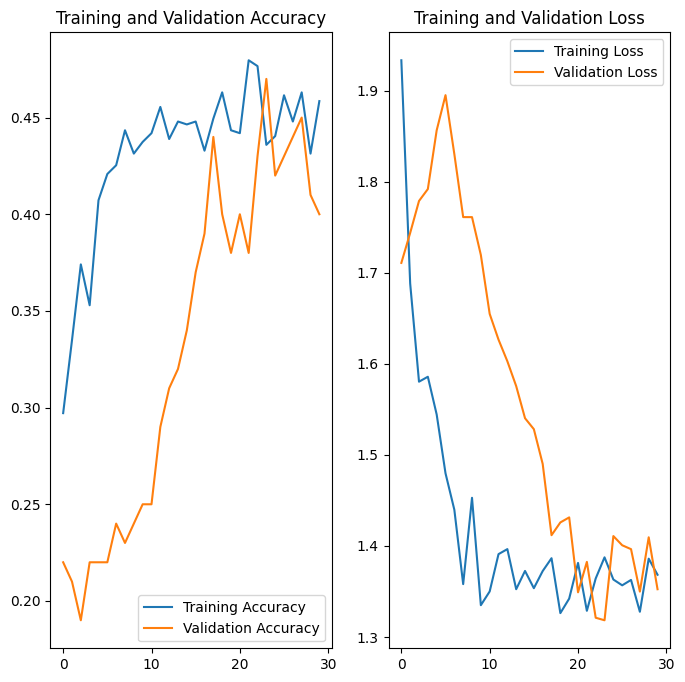

In [116]:
#Visualization
#plot(conv3d_model2,30) #num_epochs= in this case bcos of early stop

#### Experiment 2 :: Below is the experiment with batch size=20, image_height=120,image_width=120,frames_to_sample=25

In [102]:
# Model 

# conv3d_model2 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 20
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2596 - loss: 2.0264Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.79801, saving model to model_init_2025-03-1612_06_08.588752/model-00001-1.98167-0.27451-1.79801-0.19000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.2600 - loss: 2.0251 - val_categorical_accuracy: 0.1900 - val_loss: 1.7980 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3232 - loss: 1.6747
Epoch 2: val_loss did not improve from 1.79801
34/34 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.3229 - loss: 1.6761 - val_categorical_accuracy: 0.2300 - val_loss: 1.8100 - learning_rate: 0.0010
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3300 - loss: 1.7248
Epoch 3: val_loss did not improve f

<Figure size 1000x1000 with 0 Axes>

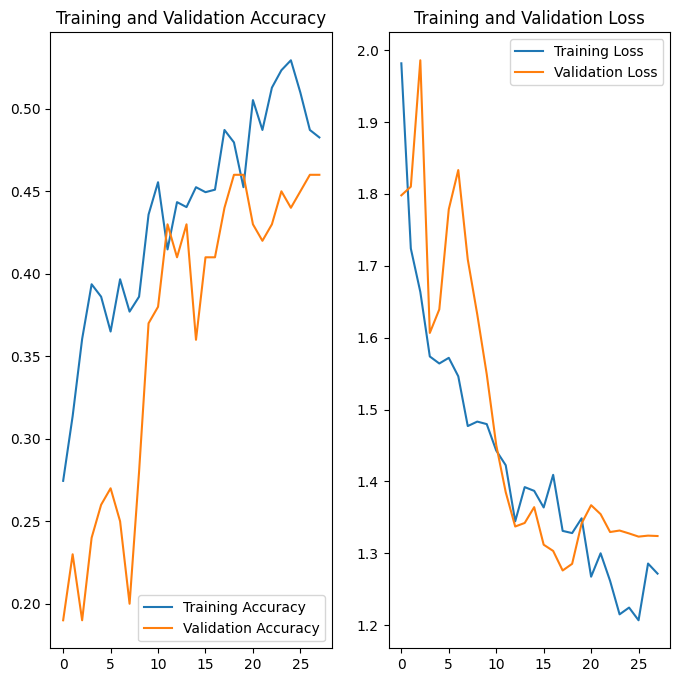

In [103]:
# Visualization
# plot(conv3d_model2,28) #num_epochs=19 in this case bcos of early stop

#### Insights: This is not good model as the training and validation accuracies are increased slowly from 25 to 50%

In [72]:
# Experiment 3 :: Below is the experiment with batch size=20,image_height=140,image_width=140,frames_to_sample=20
# Model 

# conv3d_model2 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - categorical_accuracy: 0.2505 - loss: 2.0822Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.80964, saving model to model_init_2025-03-1610_21_27.812640/model-00001-1.97894-0.28054-1.80964-0.21000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - categorical_accuracy: 0.2510 - loss: 2.0807 - val_categorical_accuracy: 0.2100 - val_loss: 1.8096 - learning_rate: 0.0020
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - categorical_accuracy: 0.2831 - loss: 1.7817
Epoch 2: val_loss did not improve from 1.80964
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 763ms/step - categorical_accuracy: 0.2831 - loss: 1.7809 - val_categorical_accuracy: 0.3200 - val_loss: 1.9697 - learning_rate: 0.0020
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - categorical_accuracy: 0.3280 - loss: 1.5982
Epoch 3: val_loss impro

<Figure size 1000x1000 with 0 Axes>

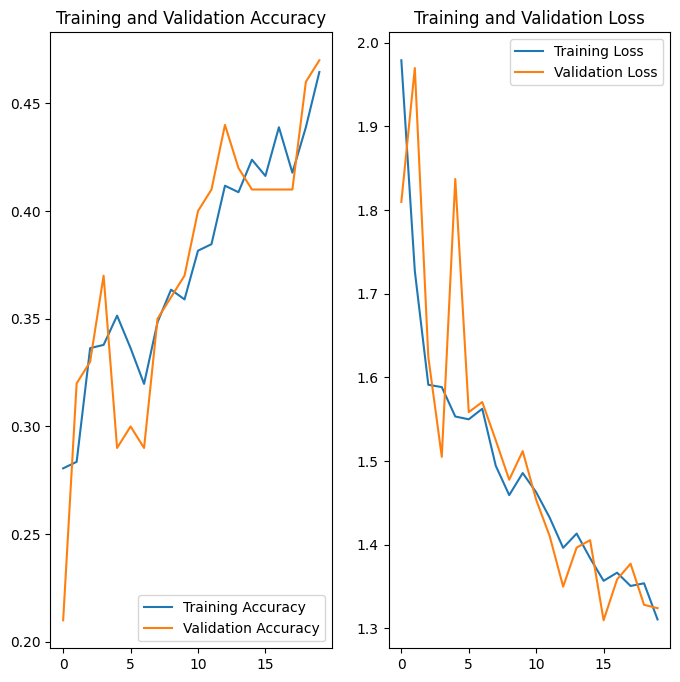

In [73]:
# Visualizing between the output and epochs

# plot(conv3d_model2,20) #num_epochs=19 in this case bcos of early stop

#### Insights: This is not good model as the training and validation accuracies are increased slowly from 25 to 47%

### Insights
#### Model: Using dropouts,BN in 3 conv and 2 FC layers. Average pooling is used in this model

Three experiments are done with different resolutions and frame_to_sample=20 or 25.

The training and validation accuracies are very low.

Needs to add one more conv layers.

## Model3-1

#### Model: No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. Maxpooling is used
#### Model is trained with 4 Conv3D layers, Flatten and 2 FC layers

In [59]:
#Model2 with No dropouts in 4 conv layers, dropouts in FC. Use BN in both conv and FC. Maxpooling is used
def define_model2(frames_to_sample,image_height,image_width,channels,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
    num_classes = 5
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
              input_shape=(frames_to_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [139]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [140]:
#Defining model

#model = define_model2(frames_to_sample,image_height,image_width,3)
#print (model.summary())

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_91 (Conv3D)                   │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_91 (Activation)           │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_143              │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_32 (MaxPooling3D)      │ (None, 10, 70, 70, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_92 (Conv3D)                   │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_92 (Activation)           │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_144              │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_33 (MaxPooling3D)      │ (None, 5, 35, 35, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_93 (Conv3D)                   │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_93 (Activation)           │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_145              │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_34 (MaxPooling3D)      │ (None, 2, 17, 17, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_94 (Conv3D)                   │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_94 (Activation)           │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_146              │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_35 (MaxPooling3D)      │ (None, 1, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_147              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [141]:
# Model 

#conv3d_model3 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3168 - loss: 1.8135   Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.82687, saving model to model_init_2025-03-1614_07_02.655049/model-00001-1.63663-0.36802-1.82687-0.30000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - categorical_accuracy: 0.3175 - loss: 1.8109 - val_categorical_accuracy: 0.3000 - val_loss: 1.8269 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - categorical_accuracy: 0.5224 - loss: 1.2491
Epoch 2: val_loss did not improve from 1.82687
67/67 ━━━━━━━━━━━━━━━━━━━━ 61s 924ms/step - categorical_accuracy: 0.5220 - loss: 1.2502 - val_categorical_accuracy: 0.2100 - val_loss: 4.8379 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - categorical_accuracy: 0.5313 - loss: 1.2616
Epoch 3: val_loss did n

<Figure size 1000x1000 with 0 Axes>

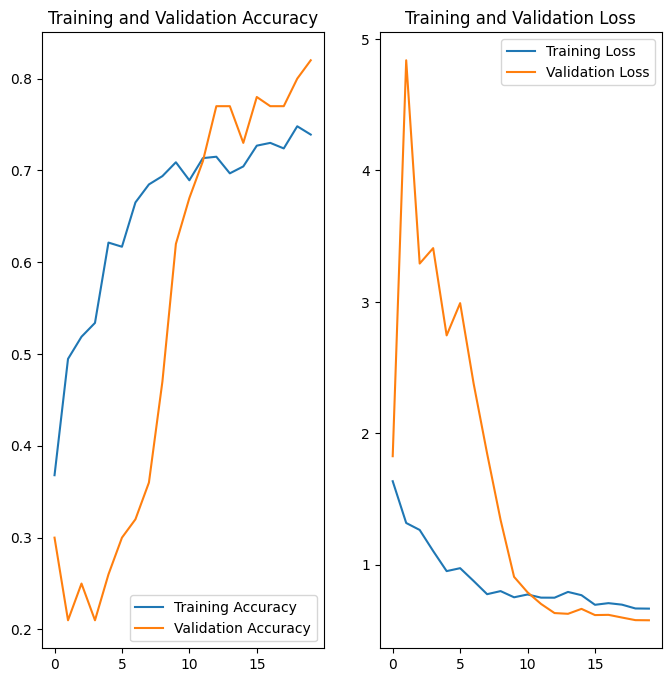

In [143]:
# Visualization plot of the results

#plot(conv3d_model3,20) #Epochs=11

### Insights
#### Model: Using No dropouts in 4 conv and 2 FC layers. Use BN. Average pooling is used in this model
epochs = 20
batch_size = 10
frames_to_sample = 20
image_height = 140
image_width = 140

For 140x140 resolution: Training Accuracy=0.7188 Val Accuracy=0.82


## Model3-2
#### Model: Using No dropouts in 4 conv and 2 FC layers. Use BN. Average pooling is used in this model

In [15]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=160
print ('# image_height =', image_height)
image_width=160
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 10
# frames_to_sample = 20
# image_height = 160
# image_width = 160


In [16]:
#Defining model

#model = define_model2(frames_to_sample,image_height,image_width,3)
#print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,940,677 (7.40 MB)

 Trainable params: 1,939,813 (7.40 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [17]:
# Model 

#conv3d_model3 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3896 - loss: 1.6398Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.92279, saving model to model_init_2025-03-1615_27_33.660552/model-00001-1.62097-0.40573-1.92279-0.25000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - categorical_accuracy: 0.3899 - loss: 1.6395 - val_categorical_accuracy: 0.2500 - val_loss: 1.9228 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - categorical_accuracy: 0.4615 - loss: 1.4016
Epoch 2: val_loss did not improve from 1.92279
67/67 ━━━━━━━━━━━━━━━━━━━━ 60s 906ms/step - categorical_accuracy: 0.4618 - loss: 1.4008 - val_categorical_accuracy: 0.1800 - val_loss: 4.5148 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - categorical_accuracy: 0.5533 - loss: 1.1251
Epoch 3: val_loss did not

<Figure size 1000x1000 with 0 Axes>

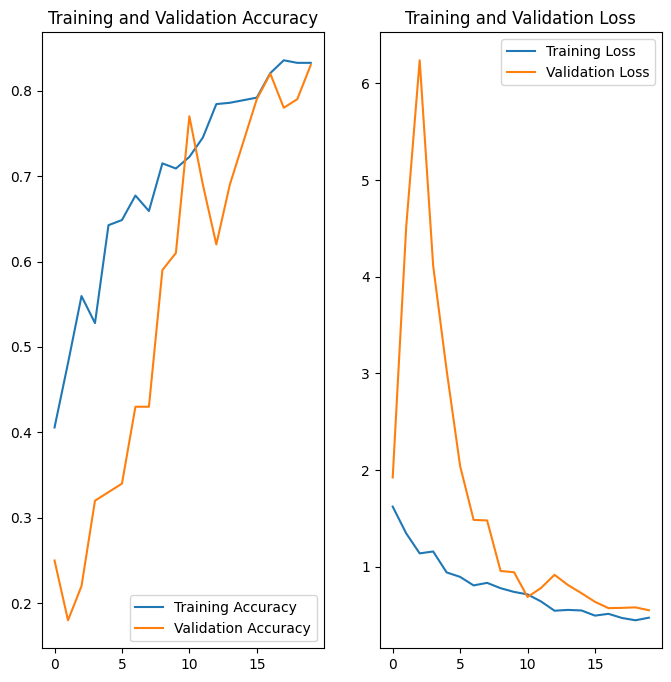

In [18]:
# Visualization plot of the results

#plot(conv3d_model3,20) #Epochs=11

### Insights
#### Model: Using No dropouts in 4 conv and 2 FC layers. Use BN. Average pooling is used in this model
epochs = 20
batch_size = 10
frames_to_sample = 20
image_height = 160
image_width = 160

For 160x160 resolution: Training Accuracy=0.7188 Val Accuracy=0.83

Model is performing well compared with previous model whereit has 3 conv layers with dropouts.

## Model4-1

#### Model: No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used instead of MaxPooling

In [43]:
curr_dt_time = datetime.datetime.now()
#train_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\train'
#val_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [60]:
# Model with No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used instead of MaxPooling
def define_model3(frames_to_sample,image_height,image_width,channels,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
    num_classes = 5
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
              input_shape=(frames_to_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [46]:
#Defining model

#model = define_model3(frames_to_sample,image_height,image_width,3)
#print (model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_15 (Conv3D)                   │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_3                  │ (None, 10, 70, 70, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_16 (Conv3D)                   │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_4                  │ (None, 5, 35, 35, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_5                  │ (None, 2, 17, 17, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_18 (Conv3D)                   │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_6                  │ (None, 1, 8, 8, 128)        │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [47]:
# Model 
#conv3d_model4 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3088 - loss: 1.9681Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 3.76493, saving model to model_init_2025-03-1605_47_55.648713/model-00001-1.76315-0.34842-3.76493-0.19000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - categorical_accuracy: 0.3094 - loss: 1.9651 - val_categorical_accuracy: 0.1900 - val_loss: 3.7649 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4413 - loss: 1.4881
Epoch 2: val_loss improved from 3.76493 to 2.69989, saving model to model_init_2025-03-1605_47_55.648713/model-00002-1.47995-0.43891-2.69989-0.26000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - categorical_accuracy: 0.4412 - loss: 1.4879 - val_categorical_accuracy: 0.2600 - val_loss: 2.6999 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━

<Figure size 1000x1000 with 0 Axes>

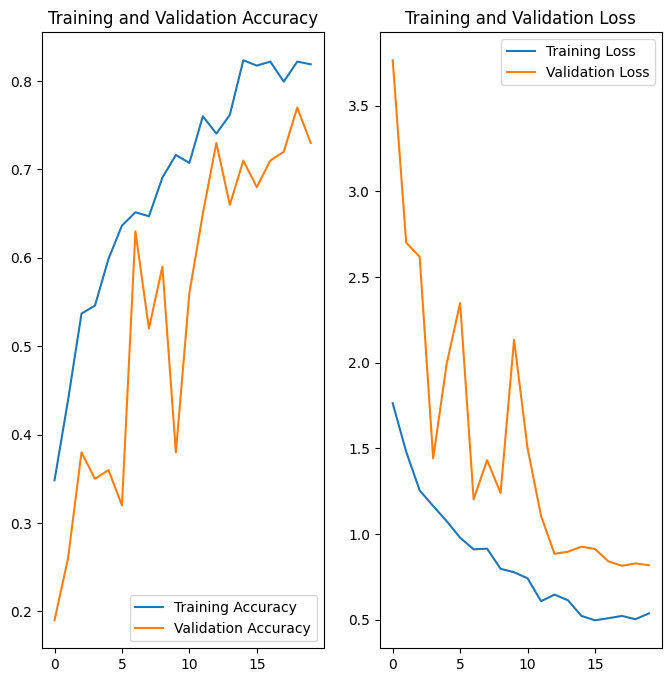

In [52]:
#Visualization
#plot(conv3d_model4,num_epochs)

### Insights

The model is overfitting and there is lot differences between training and validation accuracies.
Needs to try with less batch size and more image resolution


#### Model: No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used.

epochs = 20
batch_size = 10
frames_to_sample = 20
image_height = 140
image_width = 140

Final accuracies after 20 Epochs are Training Accuracy=0.84 Val Accuracy=0.73 where the overfitting is happening
However the best of the model is at epoch=19 where the Training Accuracy=0.7966 Val Accuracy=0.77

## Model4-2
#### Use 160x160 image resolution
#### Model: No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used instead of MaxPooling

In [20]:
curr_dt_time = datetime.datetime.now()
#train_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\train'
#val_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=160
print ('# image_height =', image_height)
image_width=160
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 10
# frames_to_sample = 20
# image_height = 160
# image_width = 160


In [21]:
#Model declaration
#model = define_model3(frames_to_sample,image_height,image_width,3)
#print (model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d (AveragePooling3D) │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_1                  │ (None, 5, 40, 40, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_2                  │ (None, 2, 20, 20, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_3                  │ (None, 1, 10, 10, 128)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,638,5

 Total params: 1,940,677 (7.40 MB)

 Trainable params: 1,939,813 (7.40 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [22]:
# Model 

#conv3d_model42 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2923 - loss: 1.9174   Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.79078, saving model to model_init_2025-03-1616_00_05.347343/model-00001-1.81368-0.32730-1.79078-0.17000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.2928 - loss: 1.9159 - val_categorical_accuracy: 0.1700 - val_loss: 1.7908 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - categorical_accuracy: 0.4312 - loss: 1.5127
Epoch 2: val_loss did not improve from 1.79078
67/67 ━━━━━━━━━━━━━━━━━━━━ 60s 911ms/step - categorical_accuracy: 0.4316 - loss: 1.5113 - val_categorical_accuracy: 0.2500 - val_loss: 2.2920 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - categorical_accuracy: 0.4987 - loss: 1.3064
Epoch 3: val_loss impro

<Figure size 1000x1000 with 0 Axes>

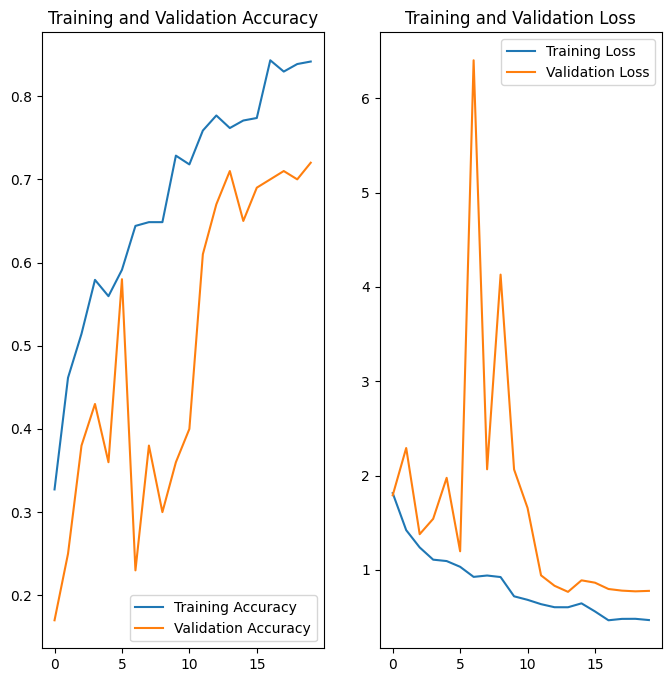

In [23]:
#Visualizing the accuracies and epochs

#plot(conv3d_model42,num_epochs)

### Insights

The model is overfitting and there is lot differences between training and validation accuracies.

#### Model: No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used.

epochs = 20
batch_size = 10
frames_to_sample = 20
image_height = 160
image_width = 160

Final accuracies after 20 Epochs are Training Accuracy=0.8359 Val Accuracy=0.72 where the overfitting is happening

## Model 5

#### Model: Using above model-define_model3 with less batch_size i.e 5. No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used instead of MaxPooling. 

In [24]:
curr_dt_time = datetime.datetime.now()
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size= 5
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# epochs = 20
# batch_size = 5
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [49]:
# Model instance

#model = define_model3(frames_to_sample,image_height,image_width,3,dropout=0.5)
#print (model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_19 (Conv3D)                   │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_7                  │ (None, 10, 70, 70, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_20 (Conv3D)                   │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_8                  │ (None, 5, 35, 35, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_9                  │ (None, 2, 17, 17, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_22 (Conv3D)                   │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_10                 │ (None, 1, 8, 8, 128)        │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [50]:
# Model execution

# conv3d_model5 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 5
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - categorical_accuracy: 0.2775 - loss: 2.3064Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 7.17837, saving model to model_init_2025-03-1606_31_59.950399/model-00001-2.22792-0.27903-7.17837-0.25000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - categorical_accuracy: 0.2775 - loss: 2.3058 - val_categorical_accuracy: 0.2500 - val_loss: 7.1784 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - categorical_accuracy: 0.2697 - loss: 2.1426
Epoch 2: val_loss improved from 7.17837 to 1.93292, saving model to model_init_2025-03-1606_31_59.950399/model-00002-2.05442-0.28658-1.93292-0.34000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - categorical_accuracy: 0.2698 - loss: 2.1420 - val_categorical_accuracy: 0.3400 - val_loss: 1.9329 - learning_rate: 0.0010
Epoch 3/

<Figure size 1000x1000 with 0 Axes>

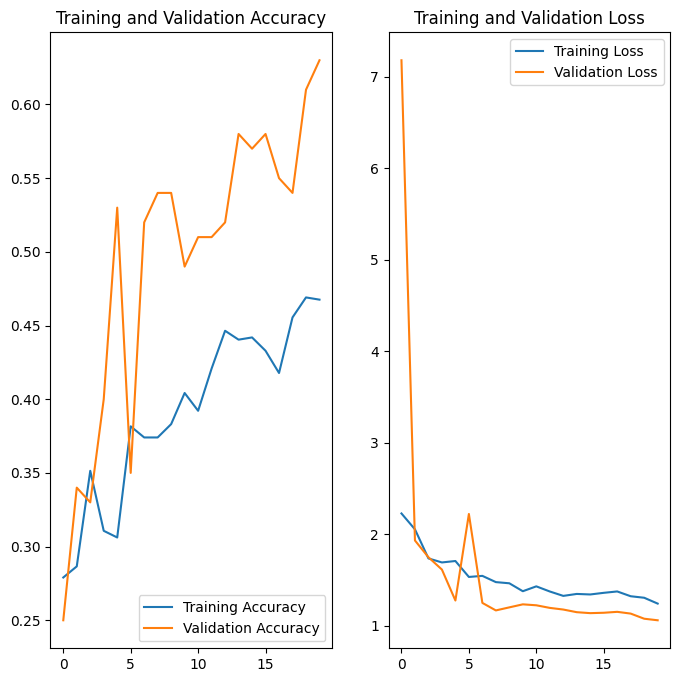

In [51]:
# Plotting between the accuracies and epochs

#plot(conv3d_model5,num_epochs)

### Insights

The model is underfitting and there is lot differences between training and validation accuracies.
So dropping this model with batchsize=5


#### Model: No dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used.

epochs = 20
batch_size = 5
frames_to_sample = 20
image_height = 140
image_width = 140

#### Final accuracies after 20 Epochs are Training Accuracy=0.4565 Val Accuracy=0.63 where the underfitting is happening


## Model6

#### Model: Creating new model4 using model3 by adding dropouts with batch_size 10. Dropouts in conv layers, dropouts in FC. Use BN in both conv and FC. AveragePooling is used. 

In [62]:
# New model with model3 with dropout = 0.25 in FC
def define_model4(frames_to_sample,image_height,image_width,channels,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
    num_classes = 5
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same',
              input_shape=(frames_to_sample,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [61]:
curr_dt_time = datetime.datetime.now()
#train_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\train'
#val_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=130
print ('# image_height =', image_height)
image_width=130
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch_size = 10
# frames_to_sample = 20
# image_height = 130
# image_width = 130


In [62]:
# Model declaration

#model = define_model4(frames_to_sample,image_height,image_width,3,dropout=0.5)
#print (model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_31 (Conv3D)                   │ (None, 20, 130, 130, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 20, 130, 130, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 20, 130, 130, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_19                 │ (None, 10, 65, 65, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 10, 65, 65, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_32 (Conv3D)                   │ (None, 10, 65, 65, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 10, 65, 65, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 10, 65, 65, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_20                 │ (None, 5, 32, 32, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 5, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_33 (Conv3D)                   │ (None, 5, 32, 32, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 5, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 5, 32, 32, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_21                 │ (None, 2, 16, 16, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 2, 16, 16, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_34 (Conv3D)                   │ (None, 2, 16, 16, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 2, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 2, 16, 16, 128)      │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [63]:
# Execute model training

#conv3d_model6 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3068 - loss: 2.3738Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.87409, saving model to model_init_2025-03-1608_28_41.258776/model-00001-2.19178-0.31523-1.87409-0.30000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - categorical_accuracy: 0.3070 - loss: 2.3711 - val_categorical_accuracy: 0.3000 - val_loss: 1.8741 - learning_rate: 0.0010
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3452 - loss: 1.8747
Epoch 2: val_loss did not improve from 1.87409
67/67 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - categorical_accuracy: 0.3453 - loss: 1.8746 - val_categorical_accuracy: 0.1800 - val_loss: 2.3761 - learning_rate: 0.0010
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4259 - loss: 1.5984
Epoch 3: val_loss did not improve

<Figure size 1000x1000 with 0 Axes>

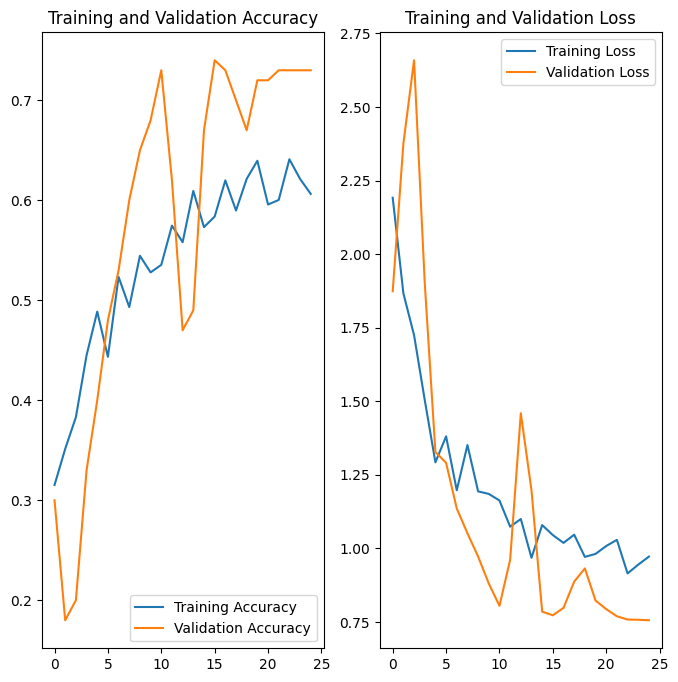

In [64]:
#plot(conv3d_model6,num_epochs)

### Insights
#### Model: Adding dropouts=0.25 after conv layers and 0.5 after FC layers for the above model. Image Resolution 130x130
epochs = 25
batch_size = 10
frames_to_sample = 20
image_height = 130
image_width = 130

For 130x130 resolution: Training Accuracy=0.6117 Val Accuracy=0.73

### Model 6
#### Model: Adding dropouts=0.25 after conv layers and 0.5 after FC layers for the above model. Image Resolution 140x140

In [26]:
curr_dt_time = datetime.datetime.now()
#train_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\train'
#val_path = r'C:\Users\gchalla\Downloads\Project_data\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [27]:
#Model declaration

#model = define_model4(frames_to_sample,image_height,image_width,3,dropout=0.5)
#print (model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)                    │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_4                  │ (None, 10, 70, 70, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 70, 70, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_5                  │ (None, 5, 35, 35, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 35, 35, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_6                  │ (None, 2, 17, 17, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 17, 17, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [28]:
# Execute model training

#conv3d_model62 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2537 - loss: 2.3063   Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 2.49868, saving model to model_init_2025-03-1616_52_16.358279/model-00001-2.17273-0.26848-2.49868-0.22000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - categorical_accuracy: 0.2539 - loss: 2.3043 - val_categorical_accuracy: 0.2200 - val_loss: 2.4987 - learning_rate: 0.0010
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - categorical_accuracy: 0.3291 - loss: 1.8180
Epoch 2: val_loss did not improve from 2.49868
67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 857ms/step - categorical_accuracy: 0.3294 - loss: 1.8179 - val_categorical_accuracy: 0.2100 - val_loss: 2.6296 - learning_rate: 0.0010
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - categorical_accuracy: 0.3740 - loss: 1.7378
Epoch 3: val_loss impro

<Figure size 1000x1000 with 0 Axes>

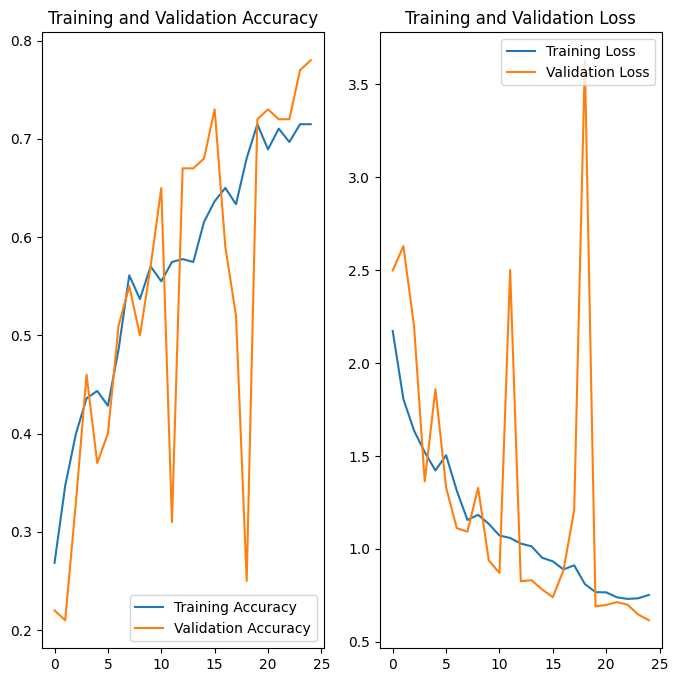

In [29]:
# Visualizing
#plot(conv3d_model62,num_epochs)

#### Insights
epochs = 25
batch_size = 10
frames_to_sample = 20
image_height = 140
image_width = 140

For 140x140 resolution: Training Accuracy=0.7076 Val Accuracy=0.78

Better than the previous resolution

### Model 7
#### Model: Adding dropouts=0.25 after conv layers and 0.25 after FC layers for the above model. Image Resolution 140x140

In [30]:
# Model declaration
#model = define_model4(frames_to_sample,image_height,image_width,3,dropout=0.25)
#print (model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)                   │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_8                  │ (None, 10, 70, 70, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 70, 70, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_9                  │ (None, 5, 35, 35, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 5, 35, 35, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_10                 │ (None, 2, 17, 17, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 17, 17, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_15 (Conv3D)                   │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [31]:
# Execute model training
# conv3d_model63 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - categorical_accuracy: 0.3161 - loss: 1.9215Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 2.27835, saving model to model_init_2025-03-1617_17_14.229516/model-00001-1.70534-0.36652-2.27835-0.20000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 75s 986ms/step - categorical_accuracy: 0.3168 - loss: 1.9184 - val_categorical_accuracy: 0.2000 - val_loss: 2.2783 - learning_rate: 0.0010
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - categorical_accuracy: 0.5105 - loss: 1.2428
Epoch 2: val_loss did not improve from 2.27835
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 845ms/step - categorical_accuracy: 0.5103 - loss: 1.2434 - val_categorical_accuracy: 0.2800 - val_loss: 3.1448 - learning_rate: 0.0010
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - categorical_accuracy: 0.5291 - loss: 1.2017
Epoch 3: val_loss im

<Figure size 1000x1000 with 0 Axes>

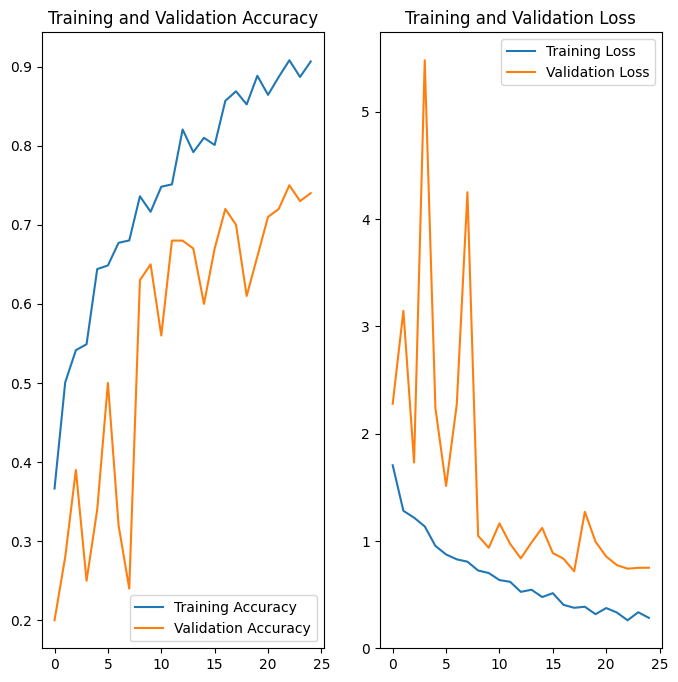

In [33]:
#Visualizing
# plot(conv3d_model63,num_epochs)

#### Insights
epochs = 25
batch_size = 10
frames_to_sample = 20
image_height = 140
image_width = 140

For 140x140 resolution: Training Accuracy=0.90 Val Accuracy=0.74

Better than the previous model

### Model 8
#### Model: Adding dropouts=0.25 after conv layers and 0.4 after FC layers for the above model. Image Resolution 140x140

In [34]:
#Model declaration
#model = define_model4(frames_to_sample,image_height,image_width,3,dropout=0.4)
#print (model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)                   │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_12                 │ (None, 10, 70, 70, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 10, 70, 70, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_13                 │ (None, 5, 35, 35, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 5, 35, 35, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_18 (Conv3D)                   │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_14                 │ (None, 2, 17, 17, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2, 17, 17, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_19 (Conv3D)                   │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [35]:
# Execute model training
# conv3d_model64 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2584 - loss: 2.2208   Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.95965, saving model to model_init_2025-03-1617_44_22.635504/model-00001-1.99918-0.31825-1.95965-0.23000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.2593 - loss: 2.2176 - val_categorical_accuracy: 0.2300 - val_loss: 1.9596 - learning_rate: 0.0010
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - categorical_accuracy: 0.4141 - loss: 1.6752
Epoch 2: val_loss did not improve from 1.95965
67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 861ms/step - categorical_accuracy: 0.4143 - loss: 1.6745 - val_categorical_accuracy: 0.2200 - val_loss: 2.3666 - learning_rate: 0.0010
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - categorical_accuracy: 0.5270 - loss: 1.2097
Epoch 3: val_loss did n

#### Insights
epochs = 25
batch_size = 10
frames_to_sample = 20
image_height = 140
image_width = 140

For 140x140 resolution: Training Accuracy=0.7450 Val Accuracy=0.69

With 0.4 dropout at FC layer has generated lesser accuracies.

Better model can be done with dropout=0.25 on FC layer.

## MODEL-9   CNNLSTM
#### 3 Conv layers with no dropouts and BN, LSTM followed by Dense layer

In [30]:
#lstm model 1 
def lstm_model1(frames_to_sample,image_height,image_width,channels,lstm_cells=64):
    input_shape = (frames_to_sample,image_height,image_width,channels)
    # Improved model with added regularization and other adjustments
    CNNlstm = Sequential()
    
    # TimeDistributed Conv Layers with L2 regularization
    CNNlstm.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
                              input_shape=input_shape))
    CNNlstm.add(TimeDistributed(BatchNormalization()))
    CNNlstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    CNNlstm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    CNNlstm.add(TimeDistributed(BatchNormalization()))
    CNNlstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    CNNlstm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    CNNlstm.add(TimeDistributed(BatchNormalization()))
    CNNlstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    CNNlstm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    CNNlstm.add(TimeDistributed(BatchNormalization()))
    CNNlstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    CNNlstm.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    CNNlstm.add(TimeDistributed(BatchNormalization()))
    CNNlstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    #CNNlstm.add(TimeDistributed(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    #CNNlstm.add(TimeDistributed(BatchNormalization()))
    #CNNlstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Flatten the output of the TimeDistributed layer
    CNNlstm.add(TimeDistributed(Flatten()))
    
    # LSTM layer with Dropout to prevent overfitting
    CNNlstm.add(LSTM(lstm_cells, return_sequences=False))
    CNNlstm.add(Dropout(0.25))
    
    # Dense Layer with Dropout for further regularization
    CNNlstm.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    CNNlstm.add(Dropout(0.25))
    
    # Output Layer for classification
    CNNlstm.add(Dense(5, activation='softmax'))
    
    # Adam optimizer with a lower learning rate for better convergence
    optimiser = optimizers.Adam(learning_rate=0.0005)
    
    # Compile model with categorical crossentropy and accuracy metric
    CNNlstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return CNNlstm

In [34]:
curr_dt_time = datetime.datetime.now()
num_epochs = 25
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# epochs = 25
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [35]:
#Model declaration

#model = lstm_model1(frames_to_sample,image_height,image_width,3,lstm_cells=128)
#print (model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_55                  │ (None, 20, 140, 140, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_56                  │ (None, 20, 140, 140, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_57                  │ (None, 20, 70, 70, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_58                  │ (None, 20, 70, 70, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_59                  │ (None, 20, 70, 70, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_60                  │ (None, 20, 35, 35, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_61                  │ (None, 20, 35, 35, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_62                  │ (None, 20, 35, 35, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_63                  │ (None, 20, 17, 17, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_64                  │ (None, 20, 17, 17, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_65                  │ (None, 20, 17, 17, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_66                  │ (None, 20, 8, 8, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_67                  │ (None, 20, 8, 8, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_68                  │ (None, 20, 8, 8, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,566,373 (9.79 MB)

 Trainable params: 2,565,381 (9.79 MB)

 Non-trainable params: 992 (3.88 KB)

None


In [36]:
# Execute model

#cnnlstm_model1 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - categorical_accuracy: 0.2694 - loss: 1.9643Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.66523, saving model to model_init_2025-03-1619_35_15.560228/model-00001-1.90145-0.32278-1.66523-0.55000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 90s 952ms/step - categorical_accuracy: 0.2702 - loss: 1.9634 - val_categorical_accuracy: 0.5500 - val_loss: 1.6652 - learning_rate: 5.0000e-04
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - categorical_accuracy: 0.4653 - loss: 1.6784
Epoch 2: val_loss improved from 1.66523 to 1.49081, saving model to model_init_2025-03-1619_35_15.560228/model-00002-1.63961-0.49774-1.49081-0.60000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 892ms/step - categorical_accuracy: 0.4658 - loss: 1.6778 - val_categorical_accuracy: 0.6000 - val_loss: 1.4908 - learning_rate: 5.0000e-04
Ep

<Figure size 1000x1000 with 0 Axes>

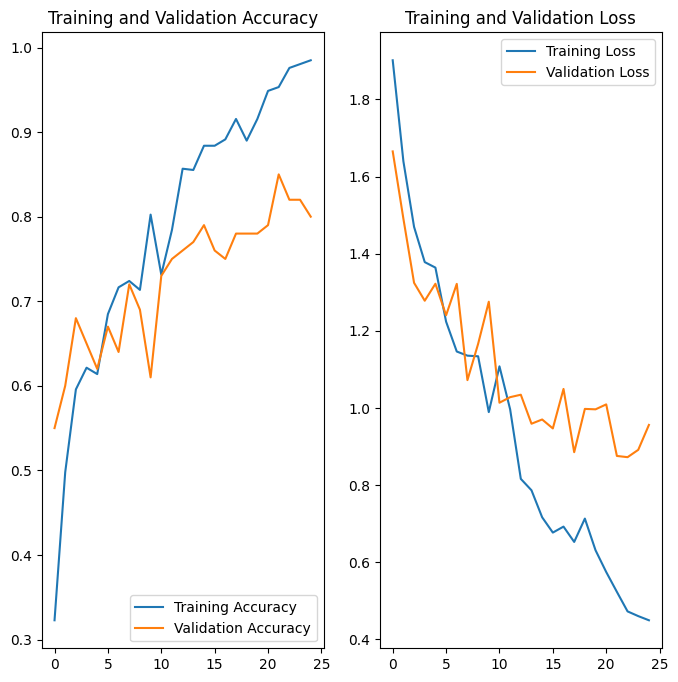

In [37]:
#plot(cnnlstm_model1,num_epochs)

#### Insights
epochs = 25
batch_size = 10
frames_to_sample = 20
image_height = 140
image_width = 140

With 140x140 resolution, the model is overfitting But got the best accuracies at Epoch 22/25.
After 25 Epochs: Training Accuracy=0.9897     Val Accuracy=0.80

At 22/25 Epoch, Training_Accuracy=0.9384     Val_Accuracy=0.85

The model is overfitting and the validation accuracy reduced

## MODEL 9-2

Using the LSTM model with 160x160 resolution

In [40]:
curr_dt_time = datetime.datetime.now()
num_epochs = 25
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=18
print ('# frames_to_sample =', frames_to_sample)
image_height=160
print ('# image_height =', image_height)
image_width=160
print ('# image_width =', image_width)

# epochs = 25
# batch_size = 10
# frames_to_sample = 18
# image_height = 160
# image_width = 160


In [41]:
#Executing the model

#model = lstm_model1(frames_to_sample,image_height,image_width,3,lstm_cells=128)
#print (model.summary())

#cnnlstm_model1 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_87                  │ (None, 18, 160, 160, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_88                  │ (None, 18, 160, 160, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_89                  │ (None, 18, 80, 80, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_90                  │ (None, 18, 80, 80, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_91                  │ (None, 18, 80, 80, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_92                  │ (None, 18, 40, 40, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_93                  │ (None, 18, 40, 40, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_94                  │ (None, 18, 40, 40, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_95                  │ (None, 18, 20, 20, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_96                  │ (None, 18, 20, 20, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_97                  │ (None, 18, 20, 20, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_98                  │ (None, 18, 10, 10, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_99                  │ (None, 18, 10, 10, 256)     │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_100                 │ (None, 18, 10, 10, 256)     │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,746,021 (14.29 MB)

 Trainable params: 3,745,029 (14.29 MB)

 Non-trainable params: 992 (3.88 KB)

None


In [42]:
# Execute model training
# cnnlstm_model2 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2804 - loss: 1.9646Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.65241, saving model to model_init_2025-03-1619_59_35.393176/model-00001-1.88161-0.33333-1.65241-0.49000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - categorical_accuracy: 0.2812 - loss: 1.9633 - val_categorical_accuracy: 0.4900 - val_loss: 1.6524 - learning_rate: 5.0000e-04
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - categorical_accuracy: 0.4740 - loss: 1.6670
Epoch 2: val_loss improved from 1.65241 to 1.51739, saving model to model_init_2025-03-1619_59_35.393176/model-00002-1.65439-0.48567-1.51739-0.58000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 894ms/step - categorical_accuracy: 0.4742 - loss: 1.6668 - val_categorical_accuracy: 0.5800 - val_loss: 1.5174 - learning_rate: 5.0000e-04
Epoch 3

<Figure size 1000x1000 with 0 Axes>

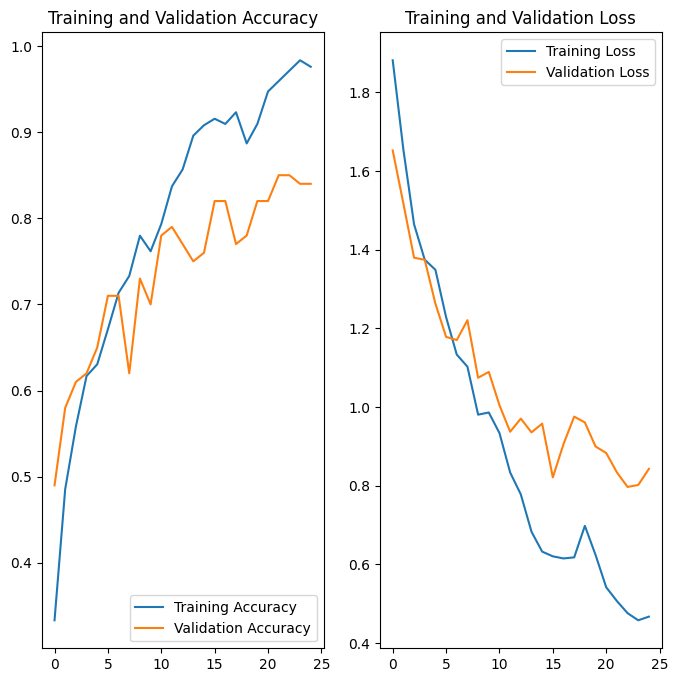

In [43]:
#plot(cnnlstm_model2,num_epochs)

#### Insights
epochs = 25
batch_size = 10
frames_to_sample = 20
image_height = 160
image_width = 160

With 160x160 resolution, the model is overfitting but got the best accuracies at Epoch 22/25. 
After 25 Epochs: Training Accuracy=0.9779     Val Accuracy=0.84

At 22/25 Epoch, Training_Accuracy=0.96     Val_Accuracy=0.85


The model is overfitting and the validation accuracy reduced


## Model10: LSTM with GRU

In [18]:
#lstm with GRU

def lstm_gru_model(frames_to_sample,image_height,image_width,channels,dropout=0.25):
    input_shape = (frames_to_sample,image_height,image_width,channels)
    GRU_lstm = Sequential()
    
    # First Conv2D Block with L2 Regularization
    GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)), input_shape=input_shape))
    GRU_lstm.add(TimeDistributed(BatchNormalization()))
    GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Second Conv2D Block
    GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    GRU_lstm.add(TimeDistributed(BatchNormalization()))
    GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Third Conv2D Block
    GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    GRU_lstm.add(TimeDistributed(BatchNormalization()))
    GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Fourth Conv2D Block
    GRU_lstm.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))))
    GRU_lstm.add(TimeDistributed(BatchNormalization()))
    GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Flatten the output of the TimeDistributed Conv layers
    GRU_lstm.add(TimeDistributed(Flatten()))
    
    # GRU Layer with increased dropout for regularization
    GRU_lstm.add(GRU(128, return_sequences=False))
    GRU_lstm.add(Dropout(dropout))

    # Fully connected Dense Layer with increased dropout and L2 regularization
    GRU_lstm.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    GRU_lstm.add(Dropout(dropout))
    
    # Output layer for classification
    GRU_lstm.add(Dense(5, activation='softmax'))
    
    # Optimizer with learning rate reduction for stable training
    optimiser = optimizers.Adam(learning_rate=0.0005)
    
    # Compile model
    GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return GRU_lstm
    

In [26]:
curr_dt_time = datetime.datetime.now()
num_epochs = 25
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=18
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# epochs = 25
# batch_size = 10
# frames_to_sample = 18
# image_height = 140
# image_width = 140


In [27]:
# Model declaration
#model = lstm_gru_model(frames_to_sample,image_height,image_width,3,dropout=0.4)
#print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_13                  │ (None, 18, 140, 140, 32)    │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 18, 140, 140, 32)    │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 18, 70, 70, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 18, 70, 70, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 18, 70, 70, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 18, 35, 35, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 18, 35, 35, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 18, 35, 35, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 18, 17, 17, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 18, 17, 17, 256)     │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 18, 17, 17, 256)     │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 18, 8, 8, 256)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 18, 16384)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │       6,341,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │              

 Total params: 6,748,869 (25.74 MB)

 Trainable params: 6,747,909 (25.74 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [28]:
# Execute model training
#lstm_gru_model1 = model_exec(model, train_path, train_doc, val_path, val_doc, batch_size, image_height, image_width, frames_to_sample, num_train_sequences, num_val_sequences, num_epochs)


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - categorical_accuracy: 0.2845 - loss: 2.1426Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.69711, saving model to model_init_2025-03-1706_09_20.585567/model-00001-2.03741-0.32579-1.69711-0.55000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.2851 - loss: 2.1410 - val_categorical_accuracy: 0.5500 - val_loss: 1.6971 - learning_rate: 5.0000e-04
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - categorical_accuracy: 0.4002 - loss: 1.8150
Epoch 2: val_loss improved from 1.69711 to 1.62728, saving model to model_init_2025-03-1706_09_20.585567/model-00002-1.87422-0.38311-1.62728-0.53000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 808ms/step - categorical_accuracy: 0.3999 - loss: 1.8159 - val_categorical_accuracy: 0.5300 - val_loss: 1.6273 - learning_rate: 5.0000e-04
Epoch

<Figure size 1000x1000 with 0 Axes>

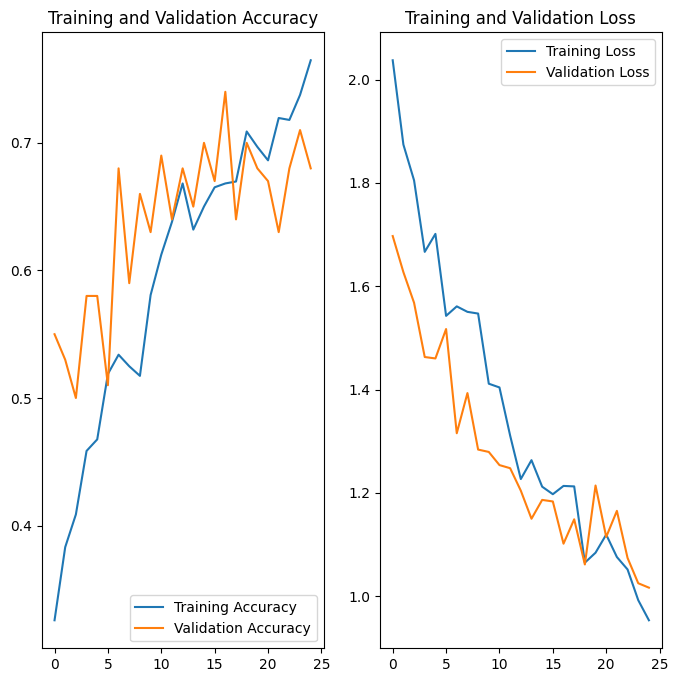

In [29]:
#plot(lstm_gru_model1,num_epochs)

#### Insights
With 140x140 resolution, the model is overfitting But got the best accuracies at Epoch 22/25.
After 25 Epochs: Training Accuracy=0.9019     Val Accuracy=0.80

We see the better modelling at Epoch 22.
Training_Accuracy= 0.8861  Val_Accuracy=0.81 (At Epoch 22/25)


### DATA AUGMENTATION ON MODELS

### MODEL 11 : USING AUGMENTATION ON DEFINE_MODEL3

In [63]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [64]:
# Model declaration
#model = define_model3(frames_to_sample,image_height,image_width,3)
#print (model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d (AveragePooling3D) │ (None, 10, 70, 70, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_1                  │ (None, 5, 35, 35, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_2                  │ (None, 2, 17, 17, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_3                  │ (None, 1, 8, 8, 128)        │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       1,048,7

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [65]:
#Model execution
#conv3d_aug_model3 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs,augmentation=True)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3508 - loss: 1.8408Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 3.54798, saving model to model_init_2025-03-1707_11_45.119719/model-00001-1.74730-0.36652-3.54798-0.18000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - categorical_accuracy: 0.3510 - loss: 1.8394 - val_categorical_accuracy: 0.1800 - val_loss: 3.5480 - learning_rate: 0.0010
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - categorical_accuracy: 0.4157 - loss: 1.4577
Epoch 2: val_loss improved from 3.54798 to 1.72712, saving model to model_init_2025-03-1707_11_45.119719/model-00002-1.46484-0.42836-1.72712-0.34000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 889ms/step - categorical_accuracy: 0.4159 - loss: 1.4579 - val_categorical_accuracy: 0.3400 - val_loss: 1.7271 - learning_rate: 0.0010
Epoch 3/30
67/67

<Figure size 1000x1000 with 0 Axes>

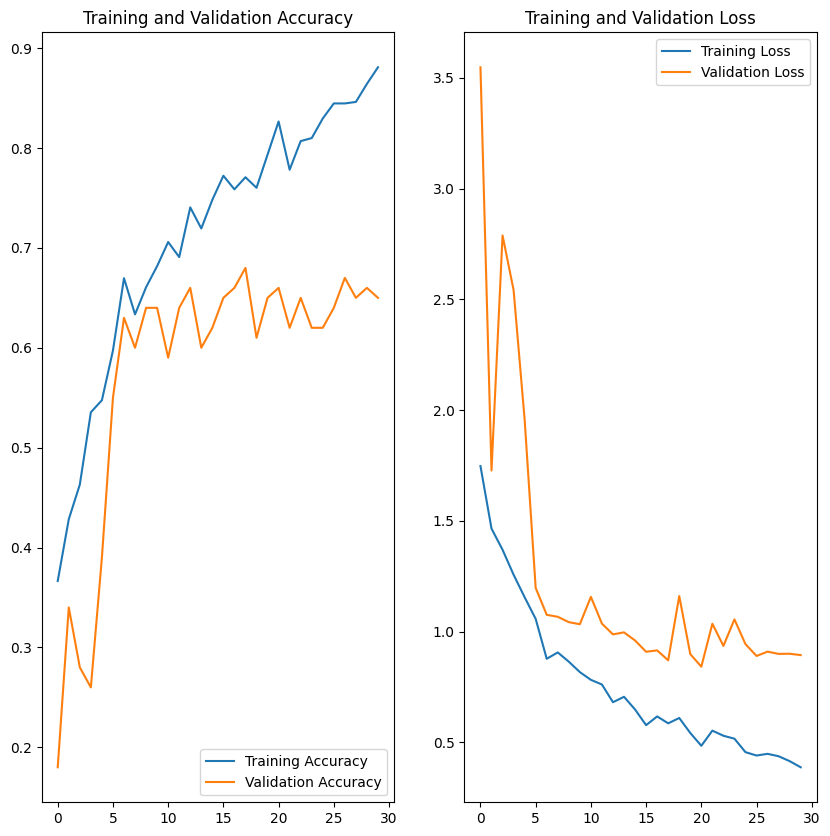

In [66]:
# Visualizing
#plot(conv3d_aug_model3,num_epochs)

#### Insights
With 140x140 resolution, the model is overfitting with data augmentation.

The accuracies are reduced a lot. Needs to go with some other model as this is not suitable.

### MODEL12 : USING AUGMENTATION ON DEFINE_MODEL4

In [67]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [68]:
# Model declaration
#model = define_model4(frames_to_sample,image_height,image_width,3,dropout=0.25)
#print (model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 140, 140, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 20, 140, 140, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 20, 140, 140, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_4                  │ (None, 10, 70, 70, 16)      │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 70, 70, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 70, 70, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10, 70, 70, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 10, 70, 70, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_5                  │ (None, 5, 35, 35, 32)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 5, 35, 35, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 35, 35, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 5, 35, 35, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 5, 35, 35, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling3d_6                  │ (None, 2, 17, 17, 64)       │               0 │
│ (AveragePooling3D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 2, 17, 17, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 17, 17, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 2, 17, 17, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 2, 17, 17, 128)      │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,350,853 (5.15 MB)

 Trainable params: 1,349,989 (5.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [69]:
#conv3d_aug_model4 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs,augmentation=True)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 10
Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - categorical_accuracy: 0.3217 - loss: 2.0163Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 2.55339, saving model to model_init_2025-03-1707_43_21.569573/model-00001-1.75897-0.37858-2.55339-0.17000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - categorical_accuracy: 0.3226 - loss: 2.0125 - val_categorical_accuracy: 0.1700 - val_loss: 2.5534 - learning_rate: 0.0010
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - categorical_accuracy: 0.5135 - loss: 1.3218
Epoch 2: val_loss improved from 2.55339 to 2.37052, saving model to model_init_2025-03-1707_43_21.569573/model-00002-1.29109-0.51131-2.37052-0.20000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 893ms/step - categorical_accuracy: 0.5135 - loss: 1.3213 - val_categorical_accuracy: 0.2000 - val_loss: 2.3705 - learning_rate: 0.0010
Epoch 3/30
67

<Figure size 1000x1000 with 0 Axes>

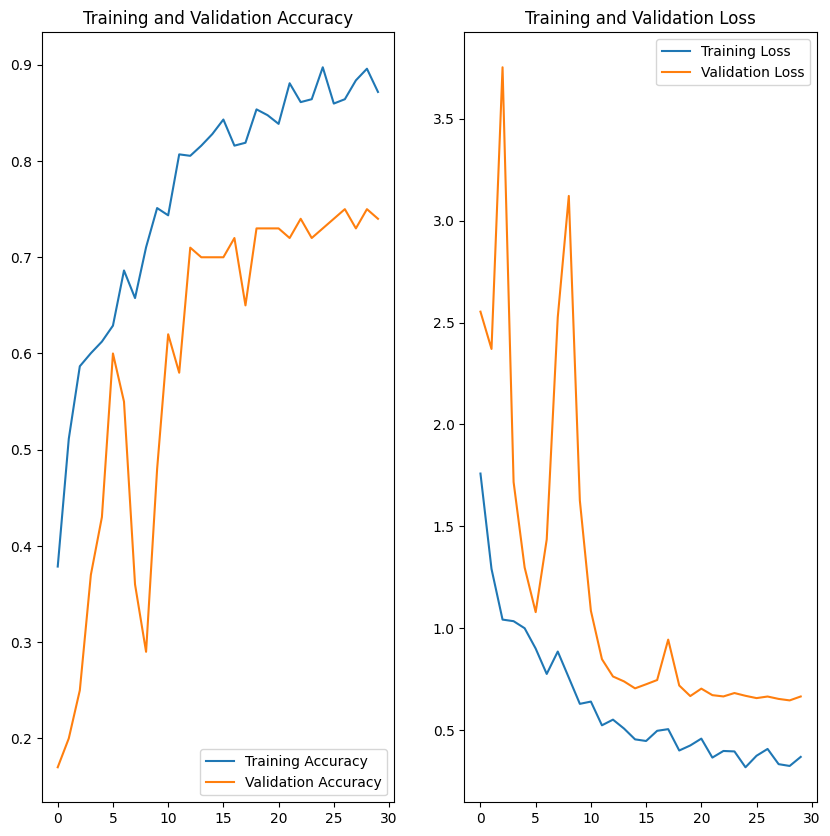

In [70]:
#Visualizing
#plot(conv3d_aug_model4,num_epochs)

#### Insights
With 140x140 resolution, the model is overfitting with data augmentation
Overfitting is reduced when compared with initial models.

Training Accuracy=0.8592  Val Accuracy=0.74

## MODEL 13 : Transfer Learning - Using MobileNet Architecture

In [53]:
# Using the mobilenet architecture
from keras.applications import mobilenet

In [59]:
#Downloading the weights
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
#Defining the model with customized layers at the bottom

def define_tl_model(frames_to_sample,image_height,image_width,channels,lstm_cells=64,dense_neurons=64,dropout=0.25):
    num_classes = 5
    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample,image_height,image_width,channels)))


    for layer in model.layers:
        layer.trainable = False


    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(num_classes, activation='softmax'))


    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [71]:
#Declaring the variables
curr_dt_time = datetime.datetime.now()
num_epochs = 10
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# epochs = 10
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [72]:
#MOdel declaration with dropout=0.5

#model = define_tl_model(frames_to_sample,image_height,image_width,3,lstm_cells=128,dense_neurons=128,dropout=0.5)
#print (model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 4096)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 128)             

In [73]:
# Executing the model with dropout=0.5
#tfl_model1 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs,augmentation=True)

Source path =  C:\Users\gchalla\Downloads\Project_data\Project_data\train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.4726 - categorical_accuracy: 0.3831Source path =  C:\Users\gchalla\Downloads\Project_data\Project_data\val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.15453, saving model to model_init_2025-03-1716_32_32.107914\model-00001-1.47256-0.38311-1.15453-0.72000.h5
67/67 [==============================] - 200s 3s/step - loss: 1.4726 - categorical_accuracy: 0.3831 - val_loss: 1.1545 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.1071 - categorical_accuracy: 0.5762
Epoch 2: val_loss improved from 1.15453 to 0.72691, saving model to model_init_2025-03-1716_32_32.107914\model-00002-1.10711-0.57617-0.72691-0.83000.h5
67/67 [==============================] - 200s 3s/step - loss: 1.1071 - categorical_accuracy: 0.5762 - val_loss: 0.7269 - val_categorical_ac

<Figure size 1000x1000 with 0 Axes>

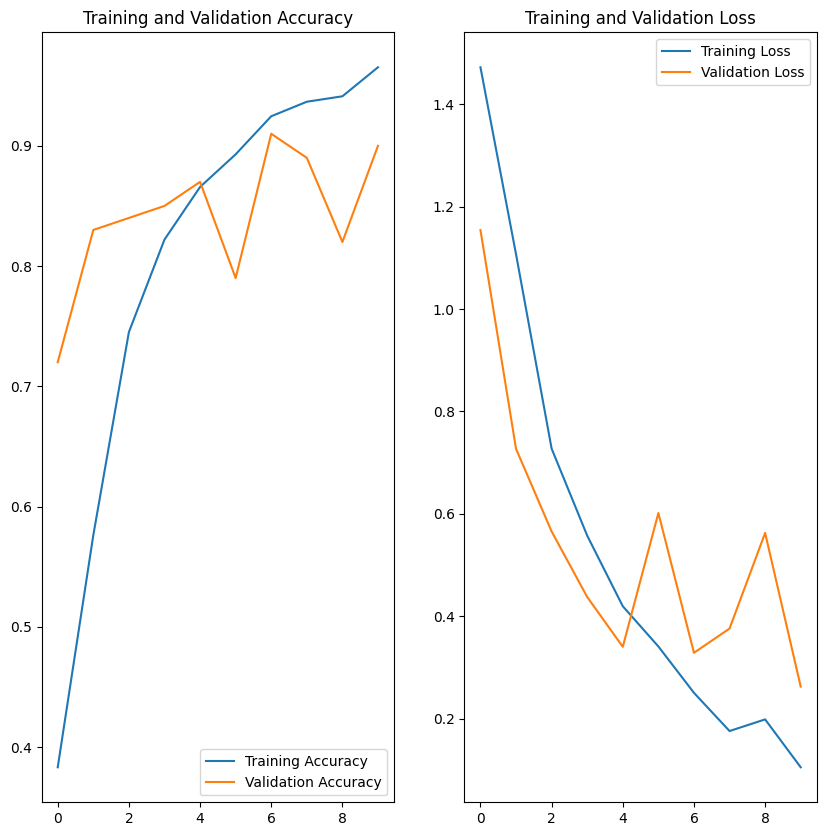

In [74]:
#Visualzing the model output
#plot(tfl_model1,10)

### Insights:

epochs = 10
batch_size = 10
frames_to_sample = 20
image_height = 140
image_width = 140

Total params: 5,413,317
Trainable params: 2,182,405
Non-trainable params: 3,230,912

Dropouts:0.5 with Augmentation
Training Accuracy=0.9653
Val Accuracy=0.90

The best weights of Transfer learning model is model-00010-0.10479-0.96531-0.26240-0.90000

#### There is significant improvement from the previous models and the accuracies are increased from lower values to more than 90 percentages.


## MODEL 14 : Transfer Learning - Using MobileNet Architecture
Using the above model define_tl_model with dropout=0.4

In [108]:
#Declaring the variables
curr_dt_time = datetime.datetime.now()
num_epochs = 10
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# epochs = 10
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [75]:
# Model declaration

model = define_tl_model(frames_to_sample,image_height,image_width,3,lstm_cells=128,dense_neurons=128,dropout=0.4)
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 20, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 4096)         0         
 stributed)                                                      
                                                                 
 lstm_6 (LSTM)               (None, 128)             

In [76]:
#Model

tfl_model2 = model_exec(model,train_path,train_doc,val_path,val_doc, batch_size,image_height,image_width,frames_to_sample,num_train_sequences,num_val_sequences,num_epochs,augmentation=False)

Source path =  C:\Users\gchalla\Downloads\Project_data\Project_data\train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.3838 - categorical_accuracy: 0.4087Source path =  C:\Users\gchalla\Downloads\Project_data\Project_data\val ; batch size = 10

Epoch 1: val_loss improved from inf to 0.98421, saving model to model_init_2025-03-1717_07_07.960764\model-00001-1.38376-0.40875-0.98421-0.75000.h5
67/67 [==============================] - 222s 3s/step - loss: 1.3838 - categorical_accuracy: 0.4087 - val_loss: 0.9842 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.8604 - categorical_accuracy: 0.6938
Epoch 2: val_loss improved from 0.98421 to 0.61450, saving model to model_init_2025-03-1717_07_07.960764\model-00002-0.86041-0.69382-0.61450-0.79000.h5
67/67 [==============================] - 217s 3s/step - loss: 0.8604 - categorical_accuracy: 0.6938 - val_loss: 0.6145 - val_categorical_ac

<Figure size 1000x1000 with 0 Axes>

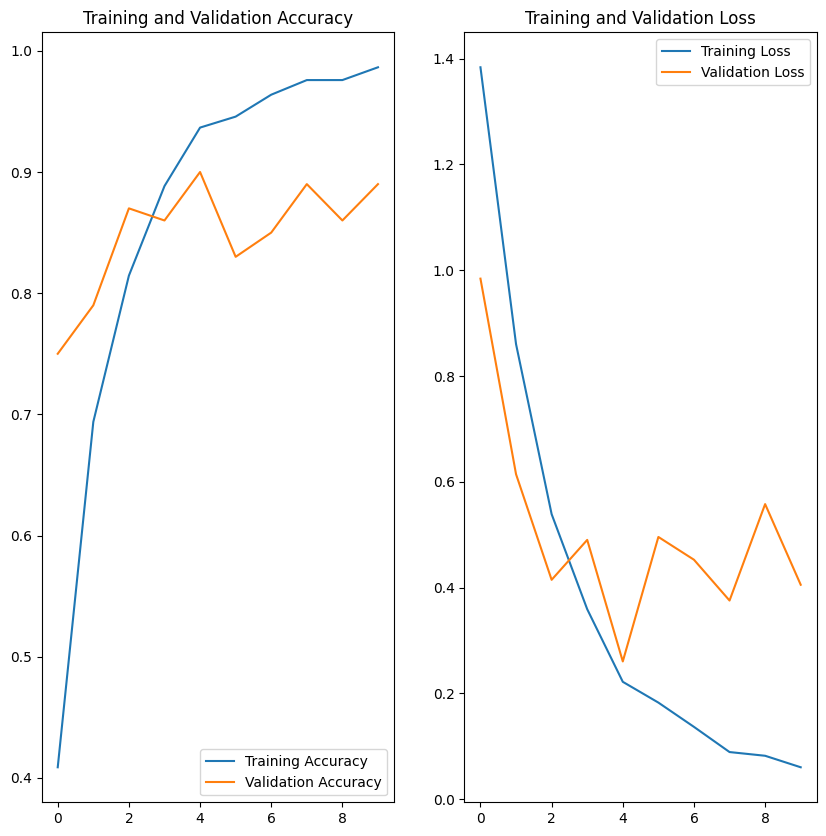

In [77]:
#Visualzing the model output
plot(tfl_model2,10)

#### Insights:
Dropouts:0.4 without Augmentation

Total params: 5,413,317
Trainable params: 2,182,405
Non-trainable params: 3,230,912

#### The best output is obtained with Epoch5/10 which has the best model. Training Accuracy=0.9367 Val Accuracy=0.90
#### The validation loss is significantly reduced in the model.

The final accuracies obtained are training accuracy=0.9864 and validation accuracy=0.89

#### There is significant improvement from the previous models and the accuracies are increased from lower values to more than 90 percentages.

#### So, this model is considered as the Final Model

## Loading model and Testing

In [86]:
import time
from keras.models import load_model
#model = load_model('model_init_2025-03-1717_07_07.960764\model-00005-0.22208-0.93665-0.26060-0.90000.h5')

In [102]:
#Declaring the variables
curr_dt_time = datetime.datetime.now()
num_epochs = 10
print ('# epochs =', num_epochs)
batch_size= 10
print ('# batch_size =', batch_size)
frames_to_sample=20
print ('# frames_to_sample =', frames_to_sample)
image_height=140
print ('# image_height =', image_height)
image_width=140
print ('# image_width =', image_width)

# epochs = 10
# batch_size = 10
# frames_to_sample = 20
# image_height = 140
# image_width = 140


In [103]:
# Declaration
#test_gen=generator(val_path,  val_doc, batch_size,image_height,image_width,frames_to_sample,augmentation=False)

In [104]:
#batch_data,batch_labels=next(test_gen)

Source path =  C:\Users\gchalla\Downloads\Project_data\Project_data\val ; batch size = 10


In [105]:
#Print batch details
#print(batch_data)

[[[[[2.94989109e-01 3.62962961e-01 4.07625258e-01]
    [2.58871973e-01 3.58436197e-01 3.93076748e-01]
    [2.50254184e-01 3.58097315e-01 3.91866416e-01]
    ...
    [3.75369191e-01 4.15649980e-01 3.40365529e-01]
    [3.60396981e-01 4.14960086e-01 3.38077962e-01]
    [3.59791815e-01 4.17550206e-01 3.30597937e-01]]

   [[2.93766677e-01 3.62490922e-01 4.07068551e-01]
    [2.60203362e-01 3.53376925e-01 3.89469862e-01]
    [2.54429936e-01 3.52045506e-01 3.88235301e-01]
    ...
    [3.81675154e-01 4.16073591e-01 3.39264125e-01]
    [3.66303563e-01 4.15504724e-01 3.36468190e-01]
    [3.71411294e-01 4.18615341e-01 3.27596247e-01]]

   [[2.85015762e-01 3.63568187e-01 4.10505950e-01]
    [2.76034862e-01 3.60518068e-01 4.02929127e-01]
    [2.80319542e-01 3.57734203e-01 3.90994906e-01]
    ...
    [3.77910942e-01 4.13640827e-01 3.32595050e-01]
    [3.69026870e-01 4.14645374e-01 3.32292438e-01]
    [3.85318339e-01 4.15383726e-01 3.30706865e-01]]

   ...

   [[5.53376973e-02 7.31542036e-02 8.0222711

In [106]:
#print batch labels
#print(batch_labels)

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [107]:
#Model predict
#print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 1s 1s/step
[2 1 4 1 4 3 3 2 3 4]


## Conclusion

•	The best results are obtained with Transfer Learning without augmentation and with dropout=0.4

•	Better results are produced while using higher image resolution in the models. Image resolution used in the final model is 140x140. Combining dropouts with batch normalization mitigated the overfitting issues and enhanced the generalization of the models.

•	Using Adam optimizer the learning rates are more adaptive when the loss is not decreasing and thus slowing rate of learning helped in improving the accuracies.

•	Final model trainable parameters:
o	Total params: 5,413,317
o	Trainable params: 2,182,405
o	Non-trainable params: 3,230,912

•	Transfer learning has significantly increased the accuracy of the model from overfitting to the best model. There is a huge shift from lower accuracy to more than 90% accuracy in both training and validation data.

•	Used image resolution with 140x140 and batch size=10 to learn the patterns in the data effectively.

•	With lesser epochs itself the best results are obtained. 
 
•	The weights of the best model is “model_init_2025-03-1717_07_07.960764\model-00005-0.22208-0.93665-0.26060-0.90000.h5” which is Epoch 5/10 of model 14